# 1)Data Preprocessing
### Data Set Information:

  The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks are presented in the original paper. The last 500,000 examples are used as a test set.


### Attribute Information:

  The first column is the class label (1 for signal, 0 for background), followed by the 28 features (21 low-level features then 7 high-level features): lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb. For more detailed information about each feature see the original paper.

### Loding the Data:

In [2]:
import pandas as pd
import numpy as np
import cuml
import cudf
import cupy
import dask_cudf
import sys
import os
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

In [3]:
cudf.set_allocator("managed")

In [4]:
columns=['class_label', 'lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

In [5]:
higgs_data = cudf.read_csv('Partical.csv', hearder=None, names=columns)

In [6]:
higgs_data.head()

,class_label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [7]:
higgs_data.shape

(11000000, 29)

In [8]:
higgs_data.describe()

,class_label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,...,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07
mean,5.299200e-01,9.914660e-01,-8.000000e-06,-1.300000e-05,9.985360e-01,2.600000e-05,9.909150e-01,-2.000000e-05,8.000000e-06,9.999690e-01,...,-6.000000e-06,1.700000e-05,1.000000e+00,1.034290e+00,1.024805e+00,1.050554e+00,1.009742e+00,9.729600e-01,1.033036e+00,9.598120e-01
std,4.991040e-01,5.653780e-01,1.008827e+00,1.006346e+00,6.000180e-01,1.006326e+00,4.749750e-01,1.009303e+00,1.005901e+00,1.027808e+00,...,1.007694e+00,1.006366e+00,1.400209e+00,6.746350e-01,3.808070e-01,1.645760e-01,3.974450e-01,5.254060e-01,3.652560e-01,3.133380e-01
min,0.000000e+00,2.746970e-01,-2.434976e+00,-1.742508e+00,2.370000e-04,-1.743944e+00,1.375020e-01,-2.969725e+00,-1.741237e+00,0.000000e+00,...,-2.497265e+00,-1.742691e+00,0.000000e+00,7.507000e-02,1.986760e-01,8.304900e-02,1.320060e-01,4.786200e-02,2.951120e-01,3.307210e-01
25%,0.000000e+00,5.907530e-01,-7.383220e-01,-8.719310e-01,5.768160e-01,-8.712080e-01,6.789930e-01,-6.872450e-01,-8.680960e-01,0.000000e+00,...,-7.141900e-01,-8.714790e-01,0.000000e+00,7.906100e-01,8.462270e-01,9.857520e-01,7.675730e-01,6.738170e-01,8.193960e-01,7.703900e-01
50%,1.000000e+00,8.533710e-01,-5.400000e-05,-2.410000e-04,8.916280e-01,2.130000e-04,8.948190e-01,-2.500000e-05,5.800000e-05,1.086538e+00,...,3.720000e-04,-2.640000e-04,0.000000e+00,8.949300e-01,9.506850e-01,9.897800e-01,9.165110e-01,8.733800e-01,9.473450e-01,8.719700e-01
75%,1.000000e+00,1.236226e+00,7.382140e-01,8.709940e-01,1.293056e+00,8.714710e-01,1.170740e+00,6.871940e-01,8.683130e-01,2.173076e+00,...,7.141020e-01,8.716050e-01,3.101961e+00,1.024730e+00,1.083493e+00,1.020528e+00,1.142226e+00,1.138439e+00,1.140458e+00,1.059248e+00
max,1.000000e+00,1.209891e+01,2.434868e+00,1.743236e+00,1.539682e+01,1.743257e+00,9.940391e+00,2.969674e+00,1.741454e+00,2.173076e+00,...,2.498009e+00,1.743372e+00,3.101961e+00,4.019237e+01,2.037278e+01,7.992739e+00,1.426244e+01,1.776285e+01,1.149652e+01,8.374498e+00


In [9]:
higgs_data.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 11000000 entries, 0 to 10999999
Data columns (total 29 columns):
 #   Column                    Dtype
---  ------                    -----
 0   class_label               float64
 1   lepton pT                 float64
 2   lepton eta                float64
 3   lepton phi                float64
 4   missing energy magnitude  float64
 5   missing energy phi        float64
 6   jet 1 pt                  float64
 7   jet 1 eta                 float64
 8   jet 1 phi                 float64
 9   jet 1 b-tag               float64
 10  jet 2 pt                  float64
 11  jet 2 eta                 float64
 12  jet 2 phi                 float64
 13  jet 2 b-tag               float64
 14  jet 3 pt                  float64
 15  jet 3 eta                 float64
 16  jet 3 phi                 float64
 17  jet 3 b-tag               float64
 18  jet 4 pt                  float64
 19  jet 4 eta                 float64
 20  jet 4 phi               

### Data visualisations:

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [12]:
event = higgs_data.iloc[:,0]
event_array = cupy.asarray(event)
noise_index = []
signal_index = []
for i in range(len(event_array)):
    if event_array[i] == 0:
        noise_index.append(i)
    if event_array[i] == 1:
        signal_index.append(i)

In [13]:
noise_index = cupy.asarray(noise_index)
signal_index = cupy.asarray(signal_index)
feature_name = ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 
                'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 
                'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 
                'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

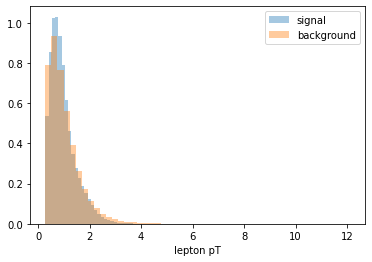

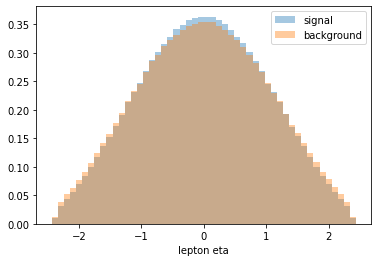

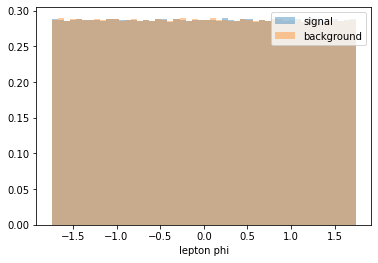

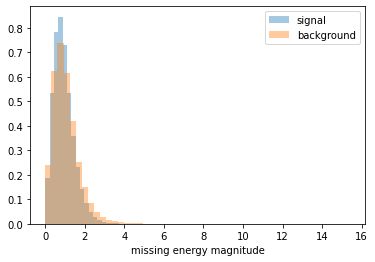

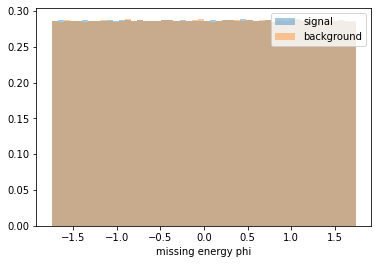

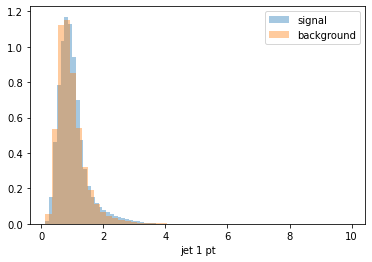

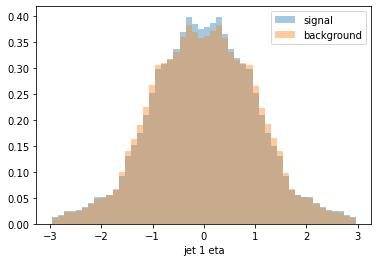

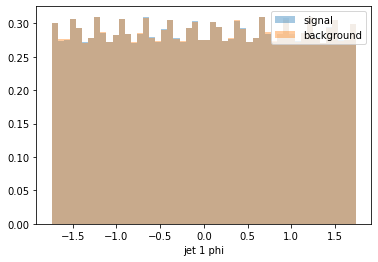

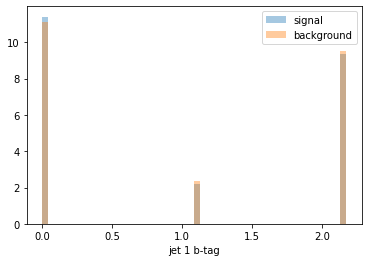

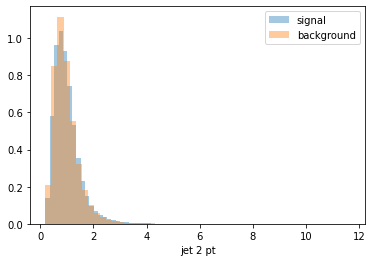

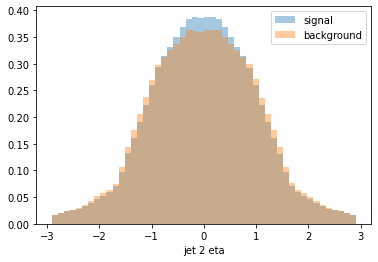

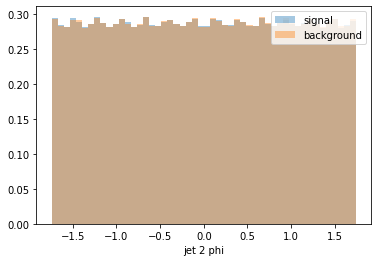

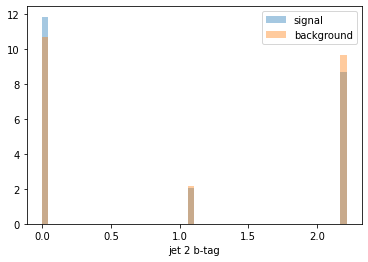

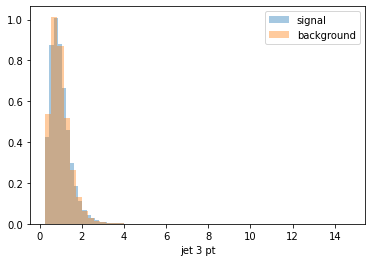

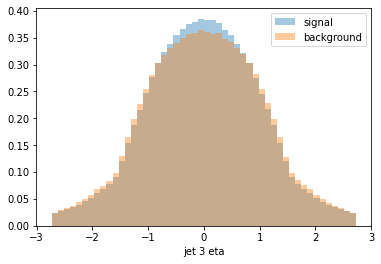

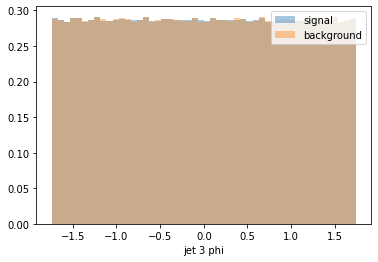

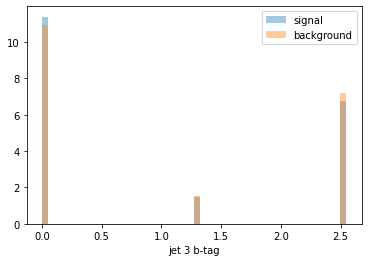

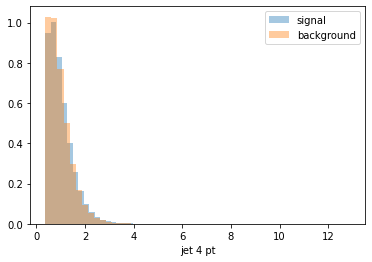

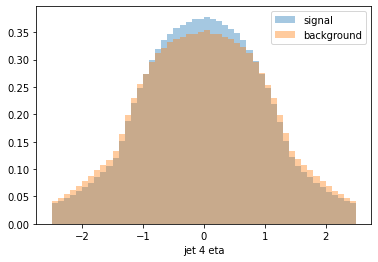

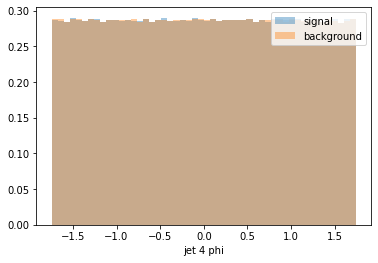

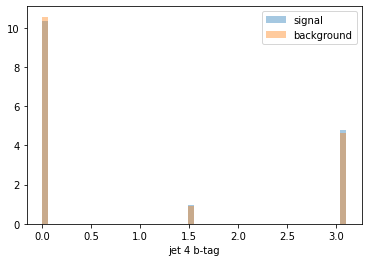

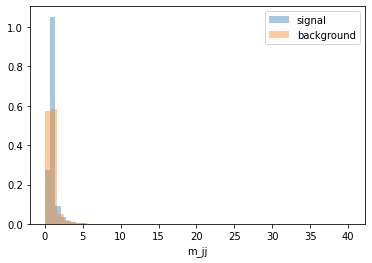

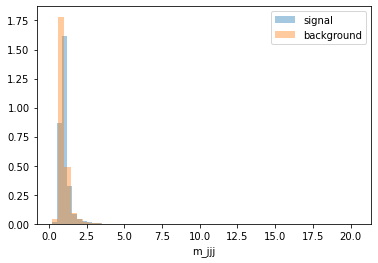

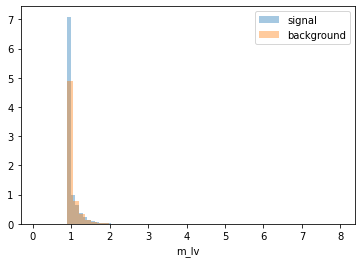

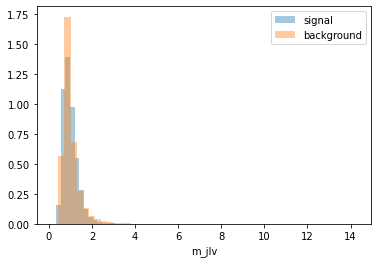

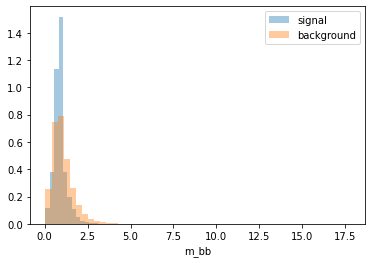

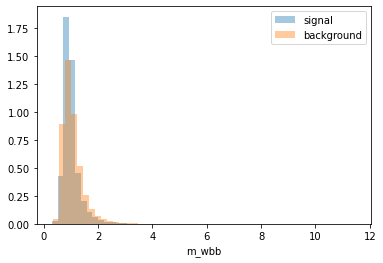

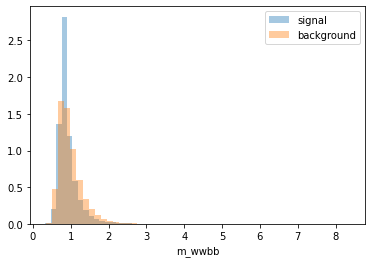

In [18]:
for j in range(1,29):
    feature = higgs_data.iloc[:,j]
    feature = cupy.asarray(feature)
    feature_noise = []
    feature_signal = []
    for i in range(len(noise_index)):
        feature_noise.append(feature[noise_index[i]])
    for i in range(len(signal_index)):
        feature_signal.append(feature[signal_index[i]])
    legend_signal = 'Feature ' + str(j)
    legend_noise = 'Noise ' + str(j)
    plt.figure(j)
    sns.distplot(feature_signal, label = 'signal', kde = False, norm_hist = True)
    sns.distplot(feature_noise, label = 'background', kde = False, norm_hist = True)
    plt.xlabel(feature_name[j-1])
    plt.legend()

Here the blue is a signal histogram and the orange is a background histogram. As you might be able to tell, the first 21 features are nearly indistinughishable from one another, but the last seven features give easily discernable differences, with different peak heights and different peak locations. These histograms make it very clear why physicists have gone the extra length to create these seven high level features.

### implement appropriate dimensionality reduction techniques with RAPIDS

In [11]:
data = higgs_data.iloc[:,1:]
data.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [12]:
labels = higgs_data.iloc[:,0]
target = higgs_data.iloc[:,0]
labels.head()

0    1.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: class_label, dtype: float64

In [13]:
import cuml; print('cuML Version:', cuml.__version__)
from cuml.decomposition import PCA as PCA_GPU
pca_gpu = PCA_GPU(n_components=20)

cuML Version: 0.18.0a+63.gae7e4442a


In [14]:
pca_gpu.fit(data)
x_pca = pca_gpu.transform(data)
x_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2.375884,-1.408481,0.098758,0.853087,-0.976186,-0.781129,-1.111108,0.266909,-0.523461,-0.766004,0.157061,-0.740828,-0.476763,0.157369,-0.734317,-0.396920,0.408683,0.083966,-0.276979,0.599181
1,-1.001335,-1.178153,1.974633,-0.046682,-1.868243,-0.672984,0.386906,0.524796,-0.742173,0.583313,0.615752,-1.165131,-0.172281,-0.507668,-0.024181,0.219316,-0.675751,-0.425963,0.295868,0.181993
2,-1.461409,2.602079,-1.038770,1.502689,1.736256,-0.303969,0.478398,-1.634353,0.550997,-0.329955,0.432110,-0.821896,-0.016948,-0.016034,0.095697,-0.203596,0.251680,-0.322568,-0.425380,-0.228475
3,-0.651146,-2.392354,1.012297,1.719413,-1.478297,0.164986,-0.576784,1.178413,1.076074,-0.242123,-0.653211,-0.540779,0.539432,-0.273851,-0.085688,0.924065,0.007351,0.779739,0.685629,0.826067
4,-0.682446,-0.170064,1.103632,1.491523,-1.261936,0.001854,-0.269011,1.175451,-1.666523,0.366207,0.605369,-0.866355,1.247657,-0.312282,0.386481,-0.222548,0.066207,0.427643,0.288301,0.256019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999995,2.562432,0.868106,-0.251749,0.108469,1.364589,0.334103,-0.363881,-0.787789,-0.809327,0.615558,-0.453591,-0.282200,1.312357,-0.740266,0.656024,1.190156,0.360621,0.625020,0.565713,0.893670
10999996,2.276295,-0.467913,0.594401,-1.499716,-1.445256,0.960391,-0.492754,-0.475153,-1.300916,0.122579,0.017658,0.975410,-0.412373,0.705700,-0.543985,0.171095,-0.141495,-0.275691,-0.408760,-0.106550
10999997,-1.112840,2.082014,2.034615,0.002175,-0.221594,2.136755,0.584095,-0.827952,-1.319732,-0.633988,-0.035822,0.705074,0.955659,-0.309919,1.083825,0.468176,0.137237,-0.690645,-0.585344,0.451820
10999998,-0.583522,0.095687,1.021601,1.523090,1.622603,-1.387965,-0.460949,0.696527,0.913435,-1.306583,0.682800,0.020560,1.267296,-0.618569,-0.577231,0.214857,-0.603409,0.829080,0.882767,-0.140435


### Setting independent variable

In [15]:
import cupy
X, y = x_pca, target
X, y = X.astype(cupy.float32), y.astype(cupy.float32)
print('X: ', X.shape, X.info, 'y: ', y.shape, y.dtype)

X:  (11000000, 20) <bound method DataFrame.info of                 0         1         2         3         4         5   \
0         2.375884 -1.408481  0.098758  0.853087 -0.976186 -0.781129   
1        -1.001335 -1.178153  1.974633 -0.046682 -1.868243 -0.672984   
2        -1.461409  2.602079 -1.038770  1.502689  1.736256 -0.303969   
3        -0.651146 -2.392354  1.012297  1.719413 -1.478297  0.164986   
4        -0.682446 -0.170064  1.103631  1.491523 -1.261936  0.001854   
...            ...       ...       ...       ...       ...       ...   
10999995  2.562432  0.868106 -0.251749  0.108469  1.364589  0.334103   
10999996  2.276294 -0.467913  0.594401 -1.499717 -1.445256  0.960391   
10999997 -1.112840  2.082014  2.034615  0.002175 -0.221594  2.136755   
10999998 -0.583522  0.095687  1.021601  1.523090  1.622603 -1.387965   
10999999 -0.920517 -2.256559  1.896001 -0.063102 -1.366885 -0.914458   

                6         7         8         9         10        11  \
0        -1.

In [16]:
pca_gpu.explained_variance_ratio_

0     0.115813
1     0.096593
2     0.084512
3     0.070010
4     0.064150
5     0.056518
6     0.055588
7     0.054467
8     0.052920
9     0.044681
10    0.042485
11    0.041082
12    0.038857
13    0.037754
14    0.025550
15    0.021813
16    0.019798
17    0.018532
18    0.016483
19    0.010474
dtype: float64

### Generating train and test split:

In [17]:
import pickle
from cuml.ensemble import RandomForestClassifier as curfc
from cuml.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=0)

# 2) Training of accelerated ML models using RAPIDS
### cuml-RandomForestClassifier Model:

In [19]:
%%time
# making data ready for fit ino the RFC model
X_cudf_train =(X_train)
X_cudf_test = (X_test)

y_cudf_train = cudf.Series(y_train.values)

CPU times: user 4.27 ms, sys: 56 µs, total: 4.33 ms
Wall time: 3.52 ms


In [21]:
%%time
#Fitting the moel in RPC model
cuml_model = curfc(n_estimators=40,
                   max_depth=16,
                   max_features=1.0,
                   random_state=10)

cuml_model.fit(X_cudf_train, y_cudf_train)

CPU times: user 1min 29s, sys: 201 ms, total: 1min 29s
Wall time: 11.7 s


RandomForestClassifier(split_criterion=0, handle=<cuml.raft.common.handle.Handle object at 0x7f3950059370>, verbose=4, output_type='input')

In [22]:
%%time
#finding the accuracy score#
fil_preds_orig = cuml_model.predict(X_cudf_test)
fil_acc_orig = accuracy_score(y_test, fil_preds_orig)

CPU times: user 1.09 s, sys: 112 ms, total: 1.2 s
Wall time: 1.2 s


In [23]:
print("RFC_model_accuracy is:",fil_acc_orig)

RFC_model_accuracy is: 0.6523095369338989


### LogisticRegression Model:

In [24]:
from cuml.linear_model import LogisticRegression

In [25]:
%%time
#Fit the data  into the LRM
reg = LogisticRegression()
reg.fit(X,y)

CPU times: user 1.81 s, sys: 48.1 ms, total: 1.86 s
Wall time: 1.86 s


LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, max_iter=1000, linesearch_max_iter=50, verbose=4, l1_ratio=None, solver='qn', handle=<cuml.raft.common.handle.Handle object at 0x7f3950070c10>, output_type='input')

In [26]:
%%time
#model predictions
preds = reg.predict(X_test)
preds

CPU times: user 30 ms, sys: 11.9 ms, total: 42 ms
Wall time: 39.2 ms


0          1.0
1          1.0
2          0.0
3          1.0
4          1.0
          ... 
2199995    0.0
2199996    1.0
2199997    1.0
2199998    1.0
2199999    1.0
Length: 2200000, dtype: float32

In [27]:
%%time
#LRM prediction accuracy
preds_accuracy = accuracy_score(y_test, preds)
print("LRM_prediction_accuracy_is:",preds_accuracy)

LRM_prediction_accuracy_is: 0.5672668218612671
CPU times: user 13.5 ms, sys: 4.05 ms, total: 17.6 ms
Wall time: 15.5 ms


## benchmark between CPU and GPU:
### For CPU loding data into a dask data frame

In [28]:
import dask
import xgboost
import dask_xgboost
import dask_ml
from dask_ml.model_selection import train_test_split
import pandas as pd
import dask.dataframe as dd
import numpy as np

In [29]:
df_cpu = dd.read_csv("./Partical.csv", header=None, names=[str(x) for x in range(29)])

In [30]:
df_cpu.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [31]:
data_cpu = df_cpu.iloc[:,1:]
data_cpu.head()

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [32]:
labels_cpu = df_cpu.iloc[:,0]
labels_cpu.head()

0    1.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: 0, dtype: float64

### corelation time for cpu

CPU times: user 13min 21s, sys: 34.6 s, total: 13min 56s
Wall time: 2min 1s


<AxesSubplot:>

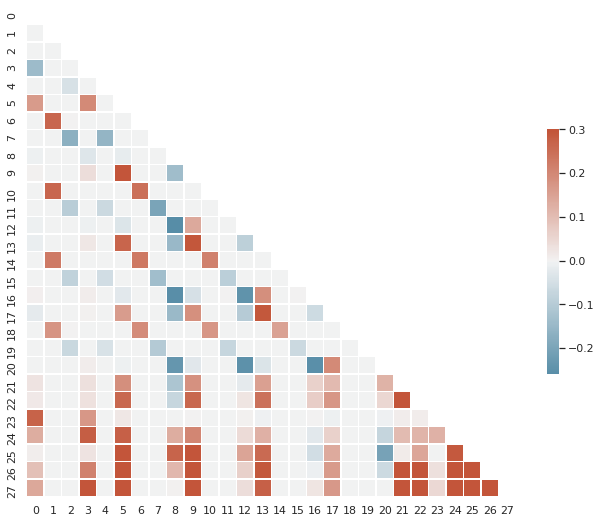

In [33]:
%%time
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_theme(style="white")


# Compute the correlation matrix
corr = data_cpu.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Drop columns 25, 26, 27 for fast and efficient training (as they show very high correlation)

In [34]:
data_cpu1 = data_cpu.drop(['25','26','27'], axis=1)

In [35]:
data_cpu1.head()

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,28
0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,...,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.876678
1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,...,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.798343
2,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,...,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.780118
3,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,...,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.957904
4,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,...,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.808487


### cpu data spliit time

In [36]:
%%time
X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(data_cpu1, labels_cpu, test_size=0.0046)
X_misc_cpu, X_train_cpu, y_misc_cpu, y_train_cpu = train_test_split(data_cpu1, labels_cpu, test_size=0.2)

CPU times: user 4.18 ms, sys: 7 µs, total: 4.19 ms
Wall time: 3.66 ms


### cpu training time:

In [37]:
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:34419 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 33.59 GB


In [38]:
params = {'objective': 'binary:logistic',
          'max_depth': 12, 'eta': 0.01, 'subsample': 0.5,
          'min_child_weight': 0.5}

X_test_c = X_test_cpu
y_test_c = y_test_cpu

X_test_cpu = X_test_cpu.compute()
y_test_cpu = y_test_cpu.compute()


evals_result = {}
bst = dask_xgboost.train(client, params, X_train_cpu, y_train_cpu, num_boost_round=10, eval_set = [(X_test_cpu, y_test_cpu)], evals_result=evals_result)

### cpu model analysis time:

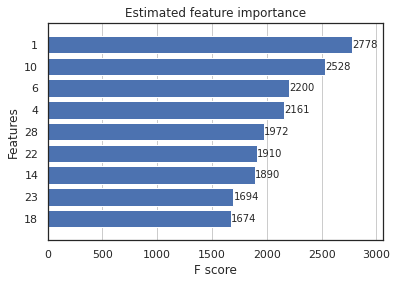

CPU times: user 239 ms, sys: 12.5 ms, total: 252 ms
Wall time: 234 ms


In [39]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [40]:
%%time
y_hat = dask_xgboost.predict(client, bst, X_test_c).persist()
y_hat

CPU times: user 645 ms, sys: 101 ms, total: 746 ms
Wall time: 389 ms


dask.array<values, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

In [41]:
y_hat = dask.compute(y_hat)
y_hat

(array([0.47545633, 0.49153873, 0.5088178 , ..., 0.5108755 , 0.45980677,
        0.507248  ], dtype=float32),)

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test_cpu, y_hat[0])

# 3)Gpu model evaluation:
### RFC model confusion matrix,sensitivity,specifity,loss and AUC values:

In [43]:
# RFC confusion matrix
y_test, fil_preds_orig= y_test.astype(cupy.int32), fil_preds_orig.astype(cupy.int32)
from cuml.metrics import confusion_matrix,roc_auc_score
RFC_confusion_materix = confusion_matrix(y_test, fil_preds_orig)

In [44]:
print("RFC_confusion_materix is:",RFC_confusion_materix)

RFC_confusion_materix is:         0       1
0  595019  438507
1  326412  840062


In [45]:
#RFC roc
RFC_roc=cuml.metrics.roc_auc_score(y_test, fil_preds_orig)
print("RFC_roc is:", RFC_roc)

RFC_roc is: 0.6479447484016418


In [46]:
#RFC p_curve
p_curve=cuml.metrics.precision_recall_curve(y_test, fil_preds_orig)
print("p_curve",p_curve)

p_curve (0    0.530215
1    0.657033
2    1.000000
dtype: float64, 0    1.000000
1    0.720172
2    0.000000
dtype: float64, 0    0
1    1
dtype: int32)


### RFC model confusion matrix,sensitivity,specifity,loss and AUC values:

In [47]:
#LRM confusion matrix
y_test, preds= y_test.astype(cupy.int32), preds.astype(cupy.int32)
from cuml.metrics import confusion_matrix,roc_auc_score
LRM_confusion_materix = confusion_matrix(y_test, preds)

In [48]:
print("LRM_confusion_materix is:", LRM_confusion_materix)

LRM_confusion_materix is:         0       1
0  432446  601080
1  350933  815541


In [49]:
#LRM roc
LRM_roc=cuml.metrics.roc_auc_score(y_test, preds)
print("LRM_roc is:", LRM_roc)

LRM_roc is: 0.5587843656539917


### Model evaluation phase on CPU:

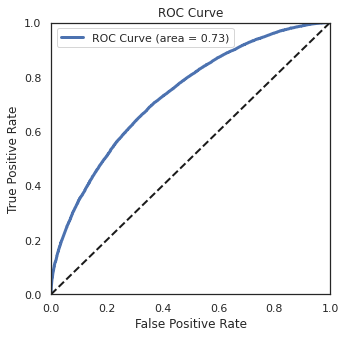

CPU times: user 164 ms, sys: 13 ms, total: 177 ms
Wall time: 153 ms


In [50]:
%%time
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()

### discussion on results
 * for the give data first we loaded it into a cudf data frame and done the preprocessing
 * then i builded the model with the cuml architecture
 * after i train the molel with 2  different frameworks
 
      i) RandomForestClassifier Model:i got accuracy in RFC is: 65%
      
      ii) LogisticRegression Model: i got accuracy in LRM is: 54%
      
### ! so as for the results we can prefare RFC  frame work to classify the model to get best results

### And also as comparision of cpu and gpu:
* I used the dask data frame and xgboost for the CPU model
#### and as shown above the time taken for each process,the cpu data frame is more higher then the time taken for the GPU data frame
### !so GPU data frame is way faster 